# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

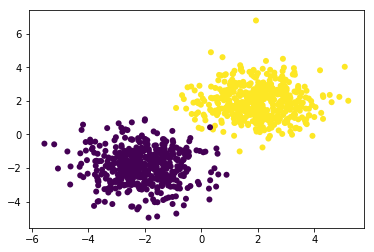

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

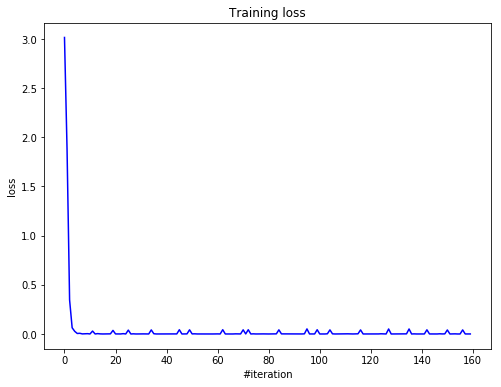

Current loss: 0.000171


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [9]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [10]:
from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [11]:
# Your code goes here. ################################################

In [12]:
def train(X, y, net, criterion, n_epoch=20, batch_size=500, lr=0.1):

    loss_history = []
    loss_history_epoch = []
    
    optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
    optimizer_state = {}
    
    start = time()
    
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
        loss_history_epoch.append(loss)
        
    end = time()
    
    return loss_history, loss_history_epoch, end - start

In [13]:
def visualize(loss_history, loss_history_batch, t, t_batch):

        display.clear_output(wait=True)
        plt.figure(figsize=(12, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.yscale('log')
        plt.plot(loss_history, 'r', alpha=0.9, label='without batch')
        plt.plot(loss_history_batch, 'b', alpha=0.7, label='with batch')
        plt.legend()
        plt.show()

        print('Loss: %f' % loss_history[-1]) 
        print('Computation time: %f' % t)
        print()
        print('Loss batch: %f' % loss_history_batch[-1]) 
        print('Computation time batch: %f' % t_batch)

In [14]:
f_linear = 256
s_linear = 30
e_linear = 10

##### ReLU

In [15]:
net_relu = Sequential()
net_relu.add(Linear(X.shape[1], f_linear))
net_relu.add(ReLU())
net_relu.add(Linear(f_linear, s_linear))
net_relu.add(ReLU())
net_relu.add(Linear(s_linear, e_linear))
net_relu.add(LogSoftMax())

criterion_relu = ClassNLLCriterion()

print(net_relu)

loss_history_relu, loss_history_epoch_relu, t_relu = train(X, y, net_relu, criterion_relu)

Linear 784 -> 256
ReLU
Linear 256 -> 30
ReLU
Linear 30 -> 10
LogSoftMax



In [16]:
net_relu_batch = Sequential()
net_relu_batch.add(Linear(X.shape[1], f_linear))
net_relu_batch.add(BatchNormalization(alpha=0.8))
net_relu_batch.add(ChannelwiseScaling(f_linear))
net_relu_batch.add(ReLU())
net_relu_batch.add(Linear(f_linear, s_linear))
net_relu_batch.add(BatchNormalization(alpha=0.8))
net_relu_batch.add(ChannelwiseScaling(s_linear))
net_relu_batch.add(ReLU())
net_relu_batch.add(Linear(s_linear, e_linear))
net_relu_batch.add(LogSoftMax())

criterion_relu_batch = ClassNLLCriterion()

print(net_relu_batch)

loss_history_batch_relu_batch, loss_history_epoch_relu_batch, t_relu_batch = train(X, y, net_relu_batch, criterion_relu_batch)

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 30
BatchNormalization
ChannelwiseScaling
ReLU
Linear 30 -> 10
LogSoftMax



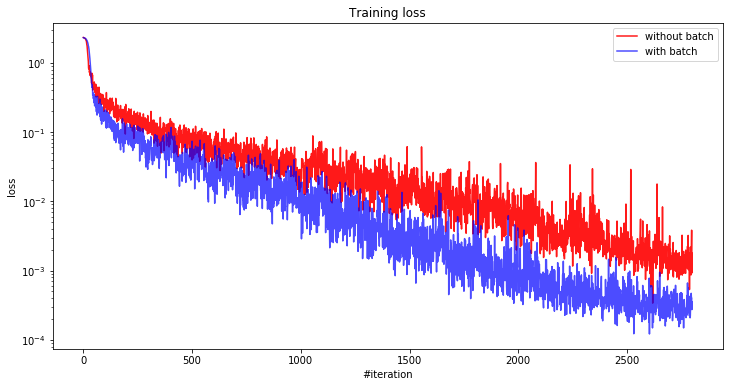

Loss: 0.001776
Computation time: 164.697305

Loss batch: 0.000354
Computation time batch: 242.735414


In [17]:
visualize(loss_history_relu, loss_history_batch_relu_batch, t_relu, t_relu_batch)

##### ELU

In [18]:
net_elu = Sequential()
net_elu.add(Linear(X.shape[1], f_linear))
net_elu.add(ELU(alpha=0.1))
net_elu.add(Linear(f_linear, s_linear))
net_elu.add(ELU(alpha=0.1))
net_elu.add(Linear(s_linear, e_linear))
net_elu.add(LogSoftMax())

criterion_elu = ClassNLLCriterion()

print(net_elu)

loss_history_elu, loss_history_epoch_elu, t_elu = train(X, y, net_elu, criterion_elu)

Linear 784 -> 256
ELU
Linear 256 -> 30
ELU
Linear 30 -> 10
LogSoftMax



In [19]:
net_elu_batch = Sequential()
net_elu_batch.add(Linear(X.shape[1], f_linear))
net_elu_batch.add(BatchNormalization(alpha=0.8))
net_elu_batch.add(ChannelwiseScaling(f_linear))
net_elu_batch.add(ELU(alpha=0.1))
net_elu_batch.add(Linear(f_linear, s_linear))
net_elu_batch.add(BatchNormalization(alpha=0.8))
net_elu_batch.add(ChannelwiseScaling(s_linear))
net_elu_batch.add(ELU(alpha=0.1))
net_elu_batch.add(Linear(s_linear, e_linear))
net_elu_batch.add(LogSoftMax())

criterion_elu_batch = ClassNLLCriterion()

print(net_elu_batch)

loss_history_elu_batch, loss_history_epoch_elu_batch, t_elu_batch = train(X, y, net_elu_batch, criterion_elu_batch)

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ELU
Linear 256 -> 30
BatchNormalization
ChannelwiseScaling
ELU
Linear 30 -> 10
LogSoftMax



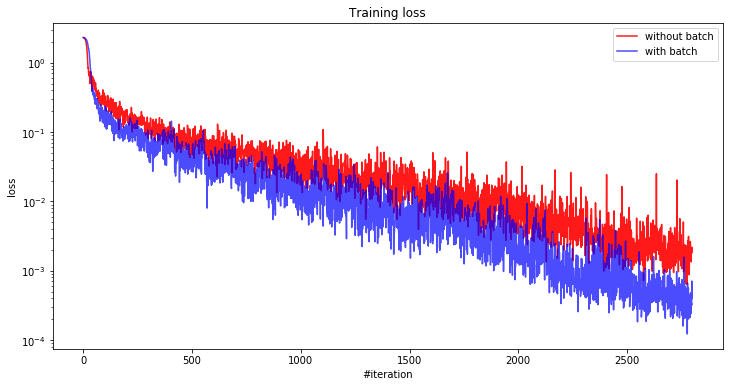

Loss: 0.002171
Computation time: 188.892744

Loss batch: 0.000400
Computation time batch: 257.167633


In [20]:
visualize(loss_history_elu, loss_history_elu_batch, t_elu, t_elu_batch)

##### LeakyReLU

In [21]:
net_leaky = Sequential()
net_leaky.add(Linear(X.shape[1], f_linear))
net_leaky.add(LeakyReLU(slope=0.05))
net_leaky.add(Linear(f_linear, s_linear))
net_leaky.add(LeakyReLU(slope=0.05))
net_leaky.add(Linear(s_linear, e_linear))
net_leaky.add(LogSoftMax())

criterion_leaky = ClassNLLCriterion()

print(net_leaky)

loss_history_leaky, loss_history_epoch_leaky, t_leaky = train(X, y, net_leaky, criterion_leaky)

Linear 784 -> 256
LeakyReLU
Linear 256 -> 30
LeakyReLU
Linear 30 -> 10
LogSoftMax



In [22]:
net_leaky_batch = Sequential()
net_leaky_batch.add(Linear(X.shape[1], f_linear))
net_leaky_batch.add(BatchNormalization(alpha=0.8))
net_leaky_batch.add(ChannelwiseScaling(f_linear))
net_leaky_batch.add(LeakyReLU(slope=0.05))
net_leaky_batch.add(Linear(f_linear, s_linear))
net_leaky_batch.add(BatchNormalization(alpha=0.8))
net_leaky_batch.add(ChannelwiseScaling(s_linear))
net_leaky_batch.add(LeakyReLU(slope=0.05))
net_leaky_batch.add(Linear(s_linear, e_linear))
net_leaky_batch.add(LogSoftMax())

criterion_leaky_batch = ClassNLLCriterion()

print(net_leaky_batch)

loss_history_leaky_batch, loss_history_epoch_leaky_batch, t_leaky_batch = train(X, y, net_leaky_batch, criterion_leaky_batch)

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 256 -> 30
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 30 -> 10
LogSoftMax



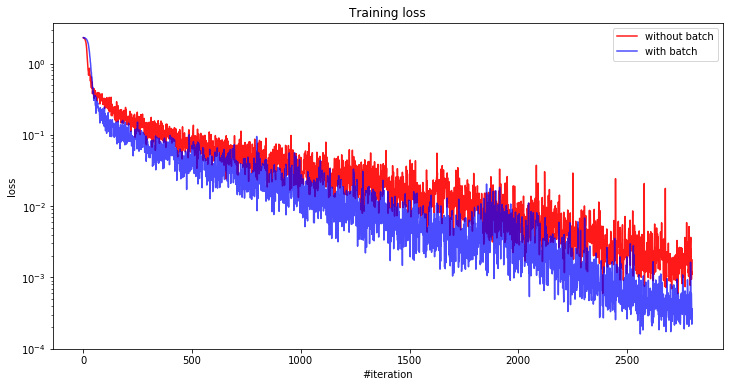

Loss: 0.001760
Computation time: 175.806516

Loss batch: 0.000364
Computation time batch: 247.048755


In [23]:
visualize(loss_history_leaky, loss_history_leaky_batch, t_leaky, t_leaky_batch)

##### SoftPlus

In [24]:
net_softplus = Sequential()
net_softplus.add(Linear(X.shape[1], f_linear))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(f_linear, s_linear))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(s_linear, e_linear))
net_softplus.add(LogSoftMax())

criterion_softplus = ClassNLLCriterion()

print(net_softplus)

loss_history_softplus, loss_history_epoch_softplus, t_softplus = train(X, y, net_softplus, criterion_softplus)

Linear 784 -> 256
SoftPlus
Linear 256 -> 30
SoftPlus
Linear 30 -> 10
LogSoftMax



In [25]:
net_softplus_batch = Sequential()
net_softplus_batch.add(Linear(X.shape[1], f_linear))
net_softplus_batch.add(BatchNormalization(alpha=0.8))
net_softplus_batch.add(ChannelwiseScaling(f_linear))
net_softplus_batch.add(SoftPlus())
net_softplus_batch.add(Linear(f_linear, s_linear))
net_softplus_batch.add(BatchNormalization(alpha=0.8))
net_softplus_batch.add(ChannelwiseScaling(s_linear))
net_softplus_batch.add(SoftPlus())
net_softplus_batch.add(Linear(s_linear, e_linear))
net_softplus_batch.add(LogSoftMax())

criterion_softplus_batch = ClassNLLCriterion()

print(net_softplus_batch)

loss_history_softplus_batch, loss_history_epoch_softplus_batch, t_softplus_batch = train(X, y, net_softplus_batch, criterion_softplus_batch)

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 256 -> 30
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 30 -> 10
LogSoftMax



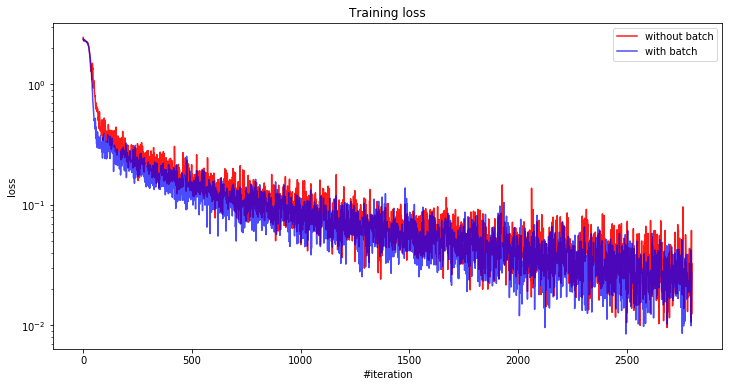

Loss: 0.032410
Computation time: 165.426802

Loss batch: 0.027143
Computation time batch: 241.553118


In [26]:
visualize(loss_history_softplus, loss_history_softplus_batch, t_softplus, t_softplus_batch)

In [27]:
print('Computation time ReLU:\t\t', t_relu)
print('Computation time ReLU + BN:\t', t_relu_batch)
print('Computation time ELU:\t\t', t_elu)
print('Computation time ELU + BN:\t', t_elu_batch)
print('Computation time LeakyReLU:\t', t_leaky)
print('Computation time LeakyReLU + BN:', t_leaky_batch)
print('Computation time SoftPlus:\t', t_softplus)
print('Computation time SoftPlus + BN:\t', t_softplus_batch)

Computation time ReLU:		 164.69730472564697
Computation time ReLU + BN:	 242.7354142665863
Computation time ELU:		 188.89274406433105
Computation time ELU + BN:	 257.16763281822205
Computation time LeakyReLU:	 175.80651569366455
Computation time LeakyReLU + BN: 247.04875493049622
Computation time SoftPlus:	 165.42680168151855
Computation time SoftPlus + BN:	 241.5531177520752


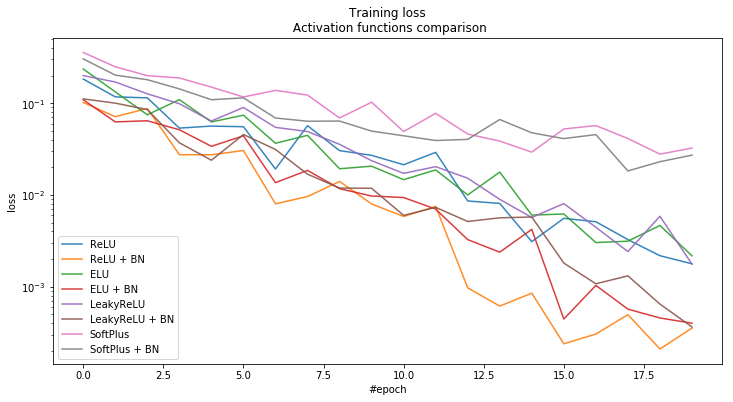

In [28]:
plt.figure(figsize=(12, 6))

plt.title("Training loss\n Activation functions comparison")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.plot(loss_history_epoch_relu, alpha=0.9, label='ReLU')
plt.plot(loss_history_epoch_relu_batch, alpha=0.9, label='ReLU + BN')
plt.plot(loss_history_epoch_elu, alpha=0.9, label='ELU')
plt.plot(loss_history_epoch_elu_batch, alpha=0.9, label='ELU + BN')
plt.plot(loss_history_epoch_leaky, alpha=0.9, label='LeakyReLU')
plt.plot(loss_history_epoch_leaky_batch, alpha=0.9, label='LeakyReLU + BN')
plt.plot(loss_history_epoch_softplus, alpha=0.9, label='SoftPlus')
plt.plot(loss_history_epoch_softplus_batch, alpha=0.9, label='SoftPlus + BN')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [29]:
# Your answer goes here. ################################################

ReLU и ReLU+BN самый оптимальный вараинт, тогда как SoftPlus самый плохой. BN картину улучшает, но время обучения возрастает.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [30]:
# Your code goes here. ################################################

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31337)

In [32]:
net_my = Sequential()
net_my.add(Linear(X.shape[1], f_linear))
net_my.add(BatchNormalization(alpha=0.8))
net_my.add(ChannelwiseScaling(f_linear))
net_my.add(ReLU())
net_my.add(Linear(f_linear, s_linear))
net_my.add(BatchNormalization(alpha=0.8))
net_my.add(ChannelwiseScaling(s_linear))
net_my.add(ReLU())
net_my.add(Linear(s_linear, e_linear))
net_my.add(LogSoftMax())

criterion_my = ClassNLLCriterion()

print(net_my)

loss_history_my, _, t_my = train(X_train, y_train, net_my, criterion_my)

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 30
BatchNormalization
ChannelwiseScaling
ReLU
Linear 30 -> 10
LogSoftMax



In [34]:
net_my.evaluate()
prediction = net_my.forward(X_test)
prediction = np.round(np.exp(prediction))

Print here your accuracy. It should be around 90%.

In [35]:
# Your answer goes here. ################################################

In [36]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(prediction, y_test)
print("Accuracy on test is", accuracy)

Accuracy on test is 0.9801428571428571


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [37]:
net_autoenc = Sequential()
net_autoenc.add(Linear(X.shape[1], 512))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(512))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(512, 256))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(256))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(256, 128))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(128))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(128, 30))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(30))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(30, 128))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(128))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(128, 256))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(256))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(256, 512))
net_autoenc.add(BatchNormalization())
net_autoenc.add(ChannelwiseScaling(512))
net_autoenc.add(ReLU())
net_autoenc.add(Linear(512, X.shape[1]))

criterion_autoenc = MSECriterion()

print(net_autoenc)

Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 30
BatchNormalization
ChannelwiseScaling
ReLU
Linear 30 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Linear 512 -> 784



In [38]:
loss_history_net_autoenc, _, t_net_autoenc = train(X_train, X_train, net_autoenc, criterion_autoenc, batch_size=512, n_epoch=20, lr=0.01)

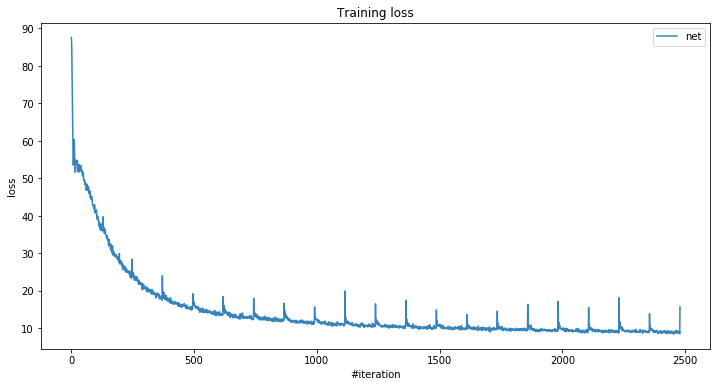

Loss: 15.756047


In [51]:
plt.figure(figsize=(12, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_net_autoenc, alpha=0.9, label='net')
plt.legend()
plt.show()

print('Loss: %f' % loss_history_net_autoenc[-1]) 

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [40]:
from copy import deepcopy
autoenc = deepcopy(net_autoenc)
del autoenc.modules[-13:]

In [41]:
autoenc.evaluate()
X_encoded = autoenc.forward(X_train)

In [42]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

criterion_cnet = ClassNLLCriterion()
loss_history_cnet, _, t_cnet = train(X_encoded, y_train, cnet, criterion_cnet, batch_size=512, n_epoch=9)

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

In [43]:
criterion_autoenc = ClassNLLCriterion()

loss_history_autoenc, _, t_autoenc = train(X_train, y_train, autoenc, criterion_autoenc, batch_size=512, n_epoch=20, lr=0.01)

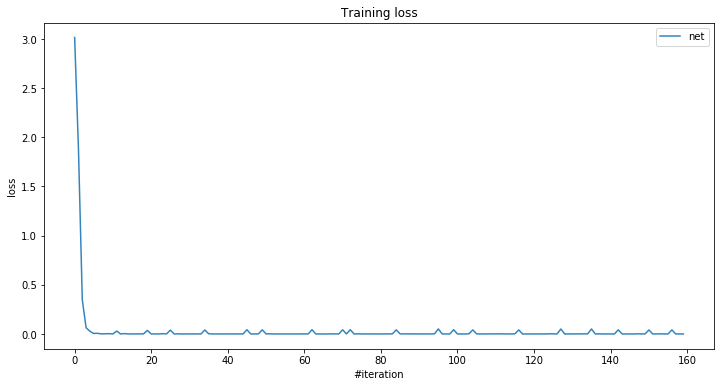

Loss: 0.000171


In [44]:
plt.figure(figsize=(12, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, alpha=0.9, label = 'net')
plt.legend()
plt.show()

print('Loss: %f' % loss_history[-1]) 

In [45]:
autoenc.evaluate()
prediction = autoenc.forward(X_test)
prediction = np.round(np.exp(prediction))

accuracy = accuracy_score(prediction, y_test)
print("Accuracy on test is", accuracy)

Accuracy on test is 0.9737142857142858


* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [46]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

In [47]:
from sklearn.decomposition import PCA

pca = PCA(30, random_state=1)
pca.fit(X_train)
X_test_pca = pca.transform(X_test)
X_test_pca = pca.inverse_transform(X_test_pca)

X_test_pca = np.clip(X_test_pca, 0, 1)

In [48]:
X_test_enc = net_autoenc.forward(X_test)
X_test_enc = np.clip(X_test_enc, 0, 1)

In [49]:
X_text_autoenc = autoenc.forward(X_test)
X_text_autoenc = np.clip(X_text_autoenc, 0, 1)

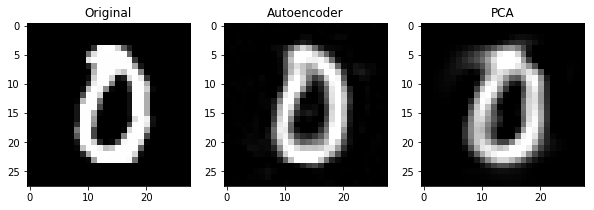

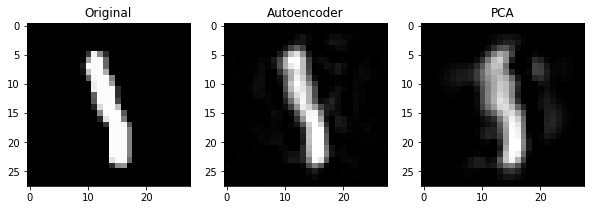

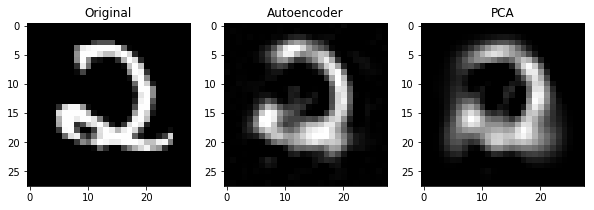

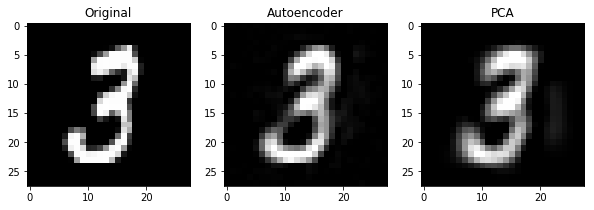

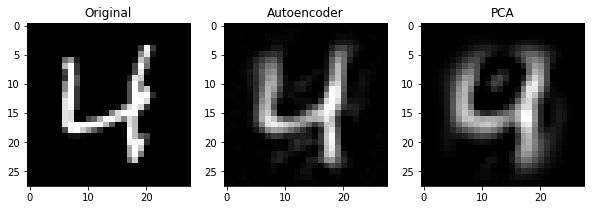

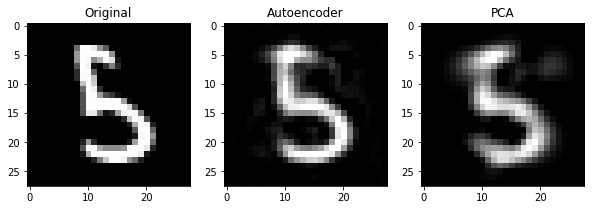

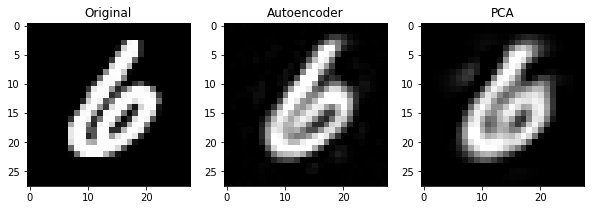

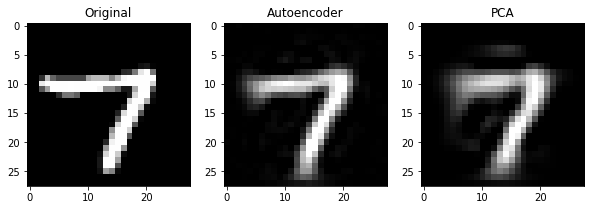

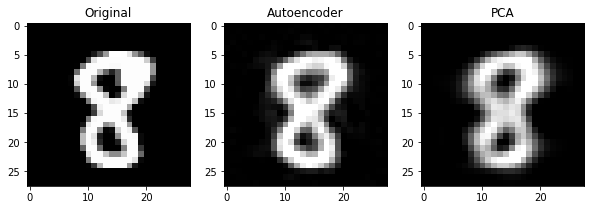

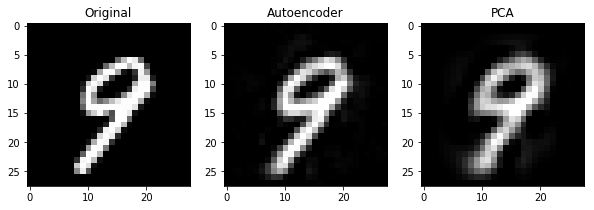

In [50]:
samples = [np.argwhere(y_test[:,i]==1)[-1][0] for i in range(10)]

for i in samples:
    plt.figure(figsize=(10, 3))
    plt.subplot(131)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.subplot(132)
    plt.imshow(X_test_enc[i].reshape(28, 28), cmap='gray')
    plt.title('Autoencoder')
    plt.subplot(133)
    plt.imshow(X_test_pca[i].reshape(28, 28), cmap='gray')
    plt.title('PCA')